In [183]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime

In [184]:
CASH_MARKET_START = pd.to_datetime("13:30:00").time() # 9:30 + 4
CASH_MARKET_END = pd.to_datetime("20:00:00").time() # 4:00 + 4

def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

In [185]:
df = pd.read_csv('./mstat.csv.gz', compression='gzip')
df['date_time'] = pd.to_datetime(df.time.str.replace('D', ' '))
df['time'] = df['date_time'].apply(lambda x : x.time())
df['time_s'] = df['time'].apply(time_to_seconds)
df['cash_hours'] = df['time'].apply(lambda x: 1 if x >= CASH_MARKET_START and x <= CASH_MARKET_END else 0)

df['first_midpoint'] = (df['firstAsk'] + df['firstBid']) / 2
df['price_change'] = df.groupby('date')['first_midpoint'].diff()
df['price_change_sq'] = df['price_change'] ** 2

# Volatility {-}

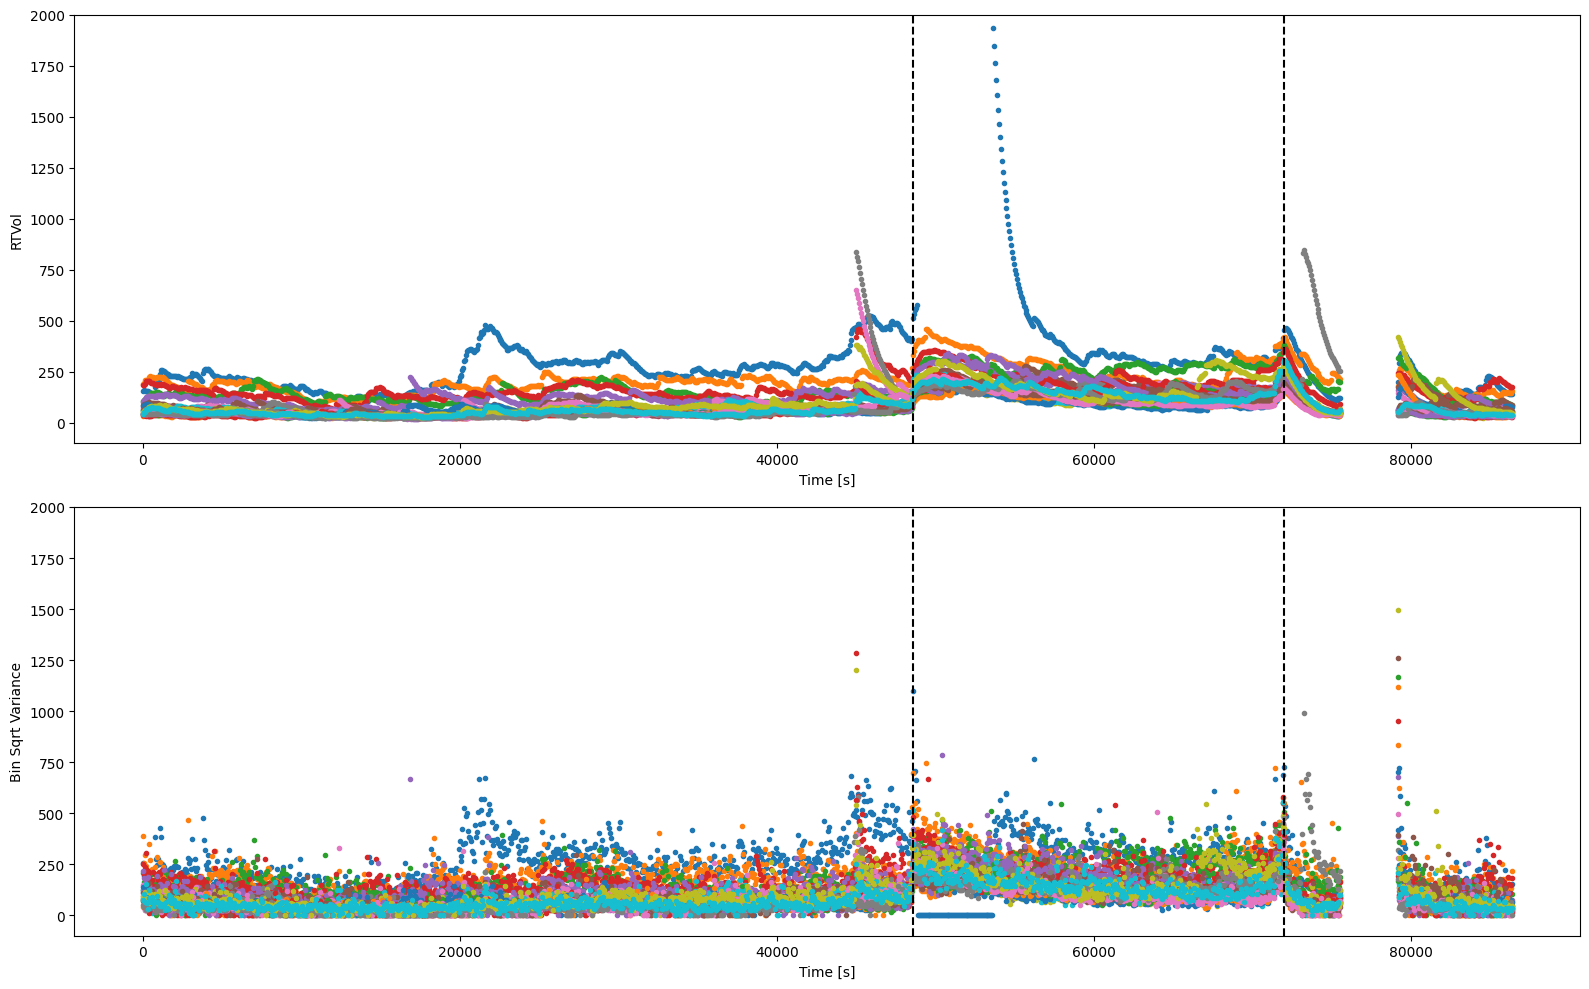

In [186]:
YLIM = (-100, 2000)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))

for date, group in df.groupby('date'):
    axs[0].scatter(group['time_s'], group['rtvol'], label=date, marker='.')
    axs[1].scatter(group['time_s'], np.sqrt(group['variance']), label=date, marker='.')

for i in [0,1]:
    axs[i].plot([time_to_seconds(CASH_MARKET_START), time_to_seconds(CASH_MARKET_START)], YLIM, 'k--')
    axs[i].plot([time_to_seconds(CASH_MARKET_END), time_to_seconds(CASH_MARKET_END)], YLIM, 'k--')
    axs[i].set_xlabel('Time [s]')
    axs[i].set_ylim(YLIM)
    # axs[i].legend()

axs[0].set_ylabel('RTVol')
axs[1].set_ylabel('Bin Sqrt Variance')

plt.tight_layout()
plt.show()

# Volume {-}

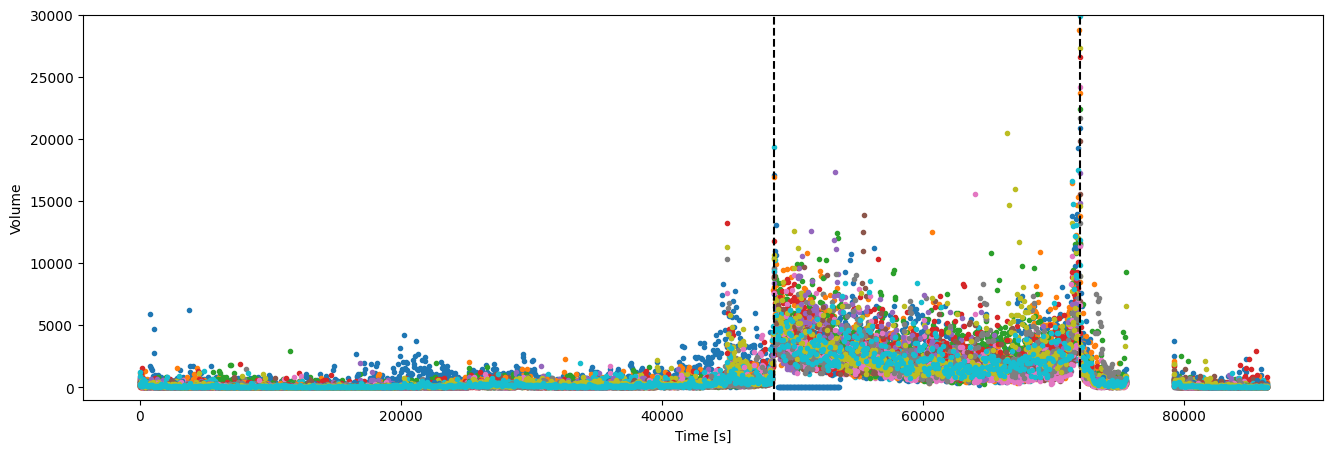

In [187]:
YLIM = (-1000, 30000)

plt.figure(figsize=(16,5))

for date, group in df.groupby('date'):
    plt.scatter(group['time_s'], group['volume'], label=date, marker='.')

plt.plot([time_to_seconds(CASH_MARKET_START),time_to_seconds(CASH_MARKET_START)], YLIM, 'k--')
plt.plot([time_to_seconds(CASH_MARKET_END),time_to_seconds(CASH_MARKET_END)], YLIM, 'k--')

plt.ylim(YLIM)
plt.xlabel('Time [s]')
plt.ylabel('Volume')
# plt.legend()

plt.show()

---

# Daily Volatility Profile $s_i$ {-}

We first calculate daily variance component $h_t$ by taking the summation of the binned variances

In [188]:
df_s_rtvol = df.copy()
df_s_variance = df.copy()

In [189]:
daily_variance = df[['date', 'variance']].groupby(['date']).sum().reset_index().rename(columns={'variance':'h_t'})
df = pd.merge(df, daily_variance, on='date')

df['s_i'] = df['price_change_sq'] / df['h_t']

s_profile = df[['time_s', 's_i']].groupby(['time_s']).mean().reset_index()

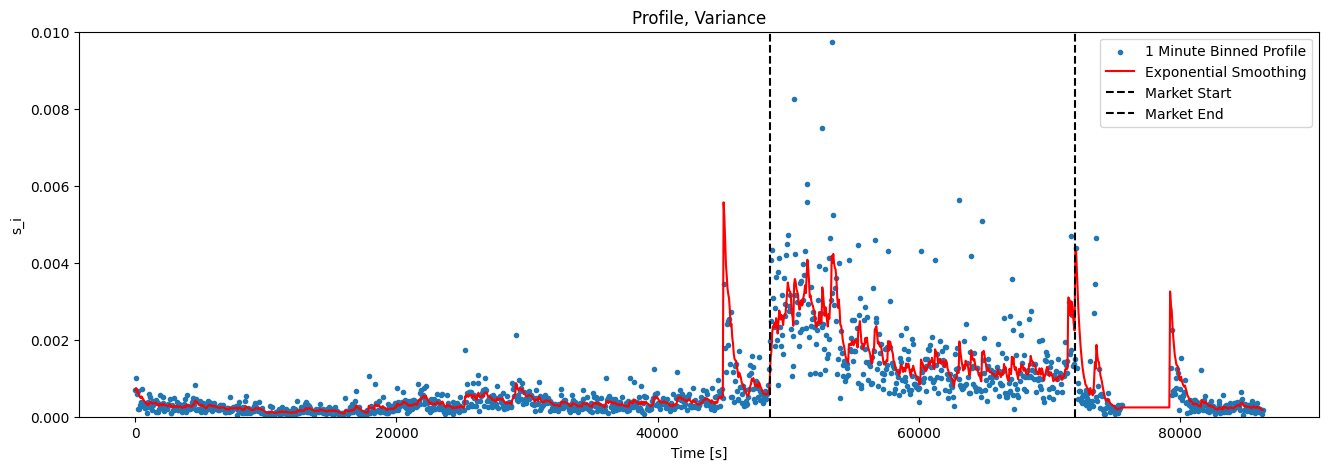

In [190]:
YLIM = (0, 0.01)

s_profile['s_i_exp_smooth'] = s_profile['s_i'].ewm(span=10, adjust=False).mean()

plt.figure(figsize=(16, 5))

plt.scatter(s_profile['time_s'], s_profile['s_i'], marker='.', label='1 Minute Binned Profile')
plt.plot(s_profile['time_s'], s_profile['s_i_exp_smooth'], color='red', label='Exponential Smoothing')

plt.plot([time_to_seconds(CASH_MARKET_START), time_to_seconds(CASH_MARKET_START)], YLIM, 'k--', label='Market Start')
plt.plot([time_to_seconds(CASH_MARKET_END), time_to_seconds(CASH_MARKET_END)], YLIM, 'k--', label='Market End')

plt.ylim(YLIM)
plt.xlabel('Time [s]')
plt.ylabel('s_i')
plt.legend()
plt.title('Profile, Variance')
plt.show()

In [191]:
daily_variance = df[['date', 'rtvol']].groupby(['date']).sum().reset_index().rename(columns={'rtvol':'h_t'})
df_s_rtvol = pd.merge(df_s_rtvol, daily_variance, on='date')

df_s_rtvol['s_i'] = df_s_rtvol['price_change_sq'] / df_s_rtvol['h_t']

s_profile_rtv = df_s_rtvol[['time_s', 's_i']].groupby(['time_s']).mean().reset_index()

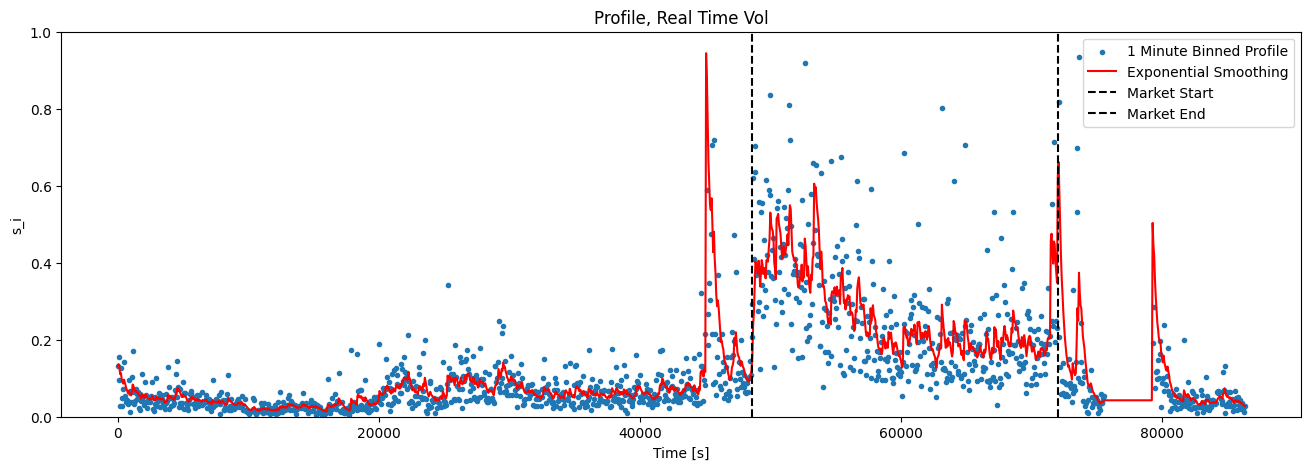

In [192]:
YLIM = (0, 1)

s_profile_rtv['s_i_exp_smooth'] = s_profile_rtv['s_i'].ewm(span=10, adjust=False).mean()

plt.figure(figsize=(16, 5))

plt.scatter(s_profile_rtv['time_s'], s_profile_rtv['s_i'], marker='.', label='1 Minute Binned Profile')
plt.plot(s_profile_rtv['time_s'], s_profile_rtv['s_i_exp_smooth'], color='red', label='Exponential Smoothing')

plt.plot([time_to_seconds(CASH_MARKET_START), time_to_seconds(CASH_MARKET_START)], YLIM, 'k--', label='Market Start')
plt.plot([time_to_seconds(CASH_MARKET_END), time_to_seconds(CASH_MARKET_END)], YLIM, 'k--', label='Market End')

plt.ylim(YLIM)
plt.xlabel('Time [s]')
plt.ylabel('s_i')
plt.legend()
plt.title('Profile, Real Time Vol')
plt.show()

---

# Stochastic Component $q_{t,i}$ {-}

In [193]:
df = df.merge(s_profile, on='time_s')
df['q_it'] = df['price_change_sq'] / (df['h_t'] * df['s_i_exp_smooth'])

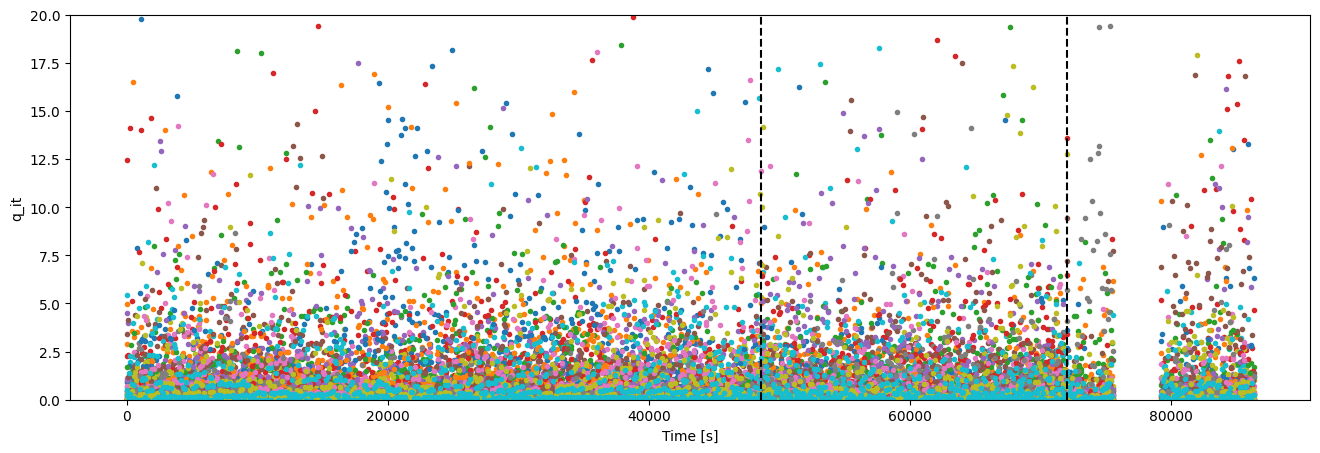

In [194]:
YLIM = (0, 20)

plt.figure(figsize=(16,5))

for date, group in df.groupby('date'):
    plt.scatter(group['time_s'], group['q_it'], label=date, marker='.')

plt.plot([time_to_seconds(CASH_MARKET_START),time_to_seconds(CASH_MARKET_START)], YLIM, 'k--')
plt.plot([time_to_seconds(CASH_MARKET_END),time_to_seconds(CASH_MARKET_END)], YLIM, 'k--')

plt.ylim(YLIM)
plt.xlabel('Time [s]')
plt.ylabel('q_it')
# plt.legend()

plt.show()

---

# Clustering on Stochastic Component $q_{t,i}$ {-}

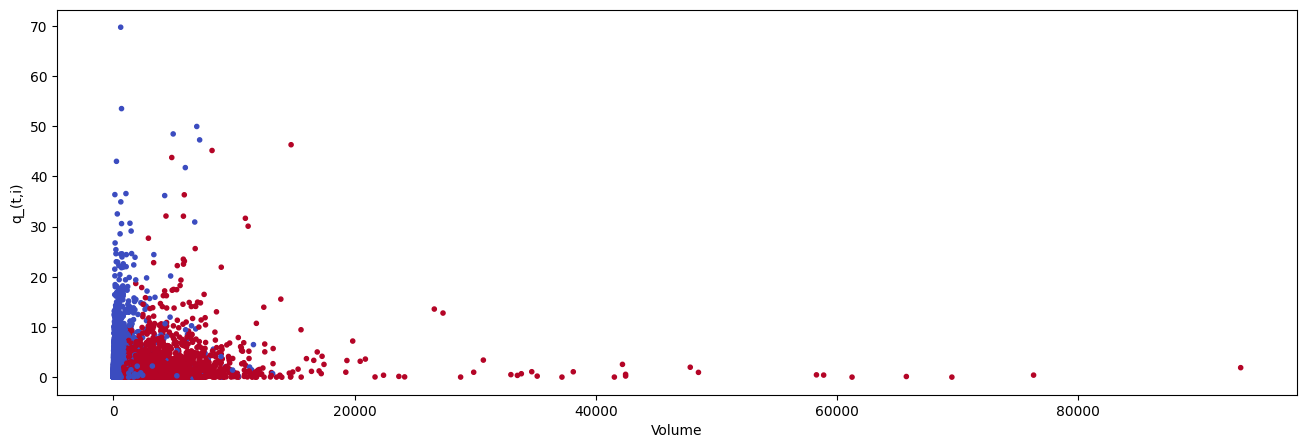

In [196]:
plt.figure(figsize=(16,5))
plt.scatter(df['volume'], df['q_it'], marker='.', c=df['cash_hours'], cmap='coolwarm')
plt.ylabel('q_(t,i)')
plt.xlabel('Volume')
plt.show()

/var/folders/f5/p6nrlq7s1zj23ymt7fncw9xm0000gn/T/ipykernel_94962/3290036014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster'] = kmeans.labels_
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


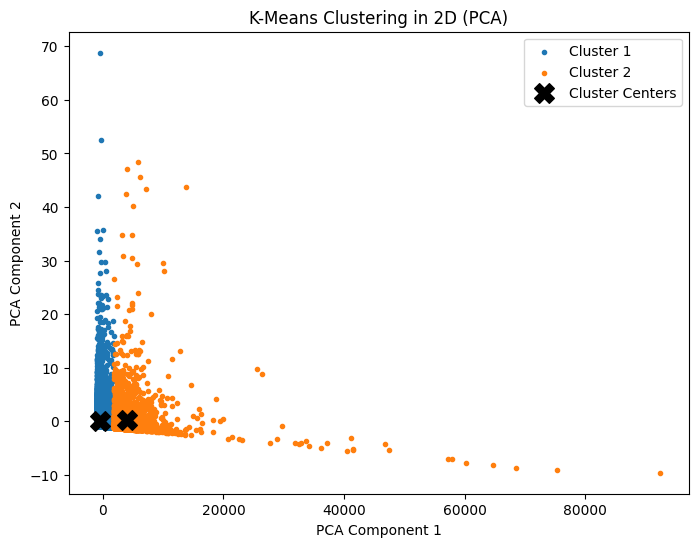

In [201]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df_temp = df.dropna(subset=['volume','q_it'])

# Define the number of clusters
cluster_n = 2
kmeans = KMeans(n_clusters=cluster_n, random_state=0).fit(df_temp[['volume', 'q_it']])
df_temp['cluster'] = kmeans.labels_

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_temp[['volume', 'q_it']])

# Plotting the 2D PCA results with clusters
plt.figure(figsize=(8, 6))
for cluster in range(cluster_n):
    cluster_data = df_pca[df_temp['cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster + 1}', marker='.')

# Plot the cluster centers (also projected to 2D with PCA)
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], s=200, color='black', marker='X', label='Cluster Centers')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering in 2D (PCA)')
plt.legend()
plt.show()
